In [529]:
# import the necessary packages
import numpy as np
import cv2
from matplotlib import pyplot as plt
import imutils
import math
import time

In [530]:
from os import listdir
from os.path import isfile, join
images_paths = sorted([f for f in listdir('../images') if isfile(join('../images', f))])

In [531]:
def detect_roi(image, visualize_bounding_box=False):
    """Detect the ROI surrounding the barcode in the given image.

    It returns the bounding box coordinates. In addition, it warps the bounding box, in order to rotate it and making the 
    bars perfectly vertical.

    This works both if the barcode is non-rotated (i.e. the bars are vertical) and if the barcode is rotated (i.e. the bars 
    are horizontal). 

    Parameters
    ----------
    image : np.array
        Input image.
    visualize_bounding_box : bool, optional
        Whether to visualize or not the input image with the detected bounding box, by default False
    visualize_final_image : bool, optional
        Whether to visualize or not the warped bounding box, by default False

    Returns
    -------
    bb_sorted : np.array
        Array 4x2, containing the coordinates of the four bounding box points. 
        The points are ordered in the following way: up-left, up-right, bottom-left, bottom-right.
    
    bb_image_warped : np.array
        Image representing the warped bounding box: the barcode bars are perfectly vertical.

    rotated : bool
        Whether the barcode was non-rotated (i.e. the bars were vertical) or rotated (i.e. the bars were horizontal).

    """

    # Convert the image to grey scale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Compute both the horizontal and vertical derivative, using the Sobel filter
    ddepth = cv2.cv.CV_32F if imutils.is_cv2() else cv2.CV_32F
    gradX = cv2.Sobel(gray, ddepth=ddepth, dx=1, dy=0, ksize=-1)
    gradY = cv2.Sobel(gray, ddepth=ddepth, dx=0, dy=1, ksize=-1)
    # Subtract the y-gradient from the x-gradient: we get the final gradient image
    gradient = cv2.subtract(gradX, gradY)
    gradient = cv2.convertScaleAbs(gradient)

    # Blur the gradient image    
    blurred = cv2.blur(gradient, (9, 9))

    # Threshold the gradient image
    _ ,thresh = cv2.threshold(blurred,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    
    # Closing: fill the bounding box
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (25, 25))
    closed = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, kernel)
    
    # Opening: remove small things outside
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (50, 50))
    opened = cv2.morphologyEx(closed, cv2.MORPH_OPEN, kernel)
    
    # Dilate: slight enlarge the box
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (8, 8))
    dilated = cv2.dilate(opened, kernel, iterations=3)
    
    # Find the bounding box (OpenCV API)
    cnts = cv2.findContours(dilated.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    c = sorted(cnts, key = cv2.contourArea, reverse = True)[0]
    # Compute the rotated bounding box of the largest contour
    rect = cv2.minAreaRect(c)
    box = cv2.cv.BoxPoints(rect) if imutils.is_cv2() else cv2.boxPoints(rect)
    # This is our bounding box: 4 points, each of them 2 coordinates
    box = np.int0(box)  

    if visualize_bounding_box:
        # Draw a bounding box around the detected barcode and display the image
        image_bb = image.copy()
        cv2.drawContours(image_bb, [box], -1, (0, 255, 0), 3)
        plt.figure()
        plt.imshow(image_bb, 'gray')
        plt.title('Original image, with the bounding box')
    
    # Sorting the points of the bounding box, such that they follow the ordering: up-left, up-right, bottom-left, bottom-right.
    bb_sorted = box.astype('float32')
    min_width = bb_sorted[:,0].min()
    min_height = bb_sorted[:,1].min()
    max_width = bb_sorted[:,0].max()
    max_height = bb_sorted[:,1].max()
    def normalize(value, axis=0):
        if axis==0:  # Horizontal dimension
            return min_width if (value-min_width<max_width-value) \
                             else max_width
        elif axis==1:  # Vertical dimension
            return min_height if (value-min_height<max_height-value) \
                              else max_height
    bb_sorted = np.array(sorted([tuple(v) for v in bb_sorted], key=lambda t: (normalize(t[1], axis=1),
                                                                                                normalize(t[0], axis=0))))
    
    # Compute the width and height of the bounding box.
    def dist(point1, point2):
        return np.sqrt(np.sum((point1-point2)**2))
    bb_height = int(max([dist(bb_sorted[0],bb_sorted[2]),
                             dist(bb_sorted[1],bb_sorted[3])]))
    bb_width = int(max([dist(bb_sorted[0],bb_sorted[1]),
                             dist(bb_sorted[2],bb_sorted[3])]))


    return bb_sorted, bb_width, bb_height

In [532]:
def rotate_image(image, angle, center):
  #image_center = tuple(np.array(image.shape[1::-1]) / 2)
  rot_mat = cv2.getRotationMatrix2D(center, angle, 1.0)
  result = cv2.warpAffine(image, rot_mat, image.shape[1::-1], flags=cv2.INTER_LINEAR)
  return result, rot_mat

In [533]:
def rotate_image_boundingBox(image, bb_sorted, bb_width, bb_height):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    point1 = bb_sorted[0, :]
    point2 = bb_sorted[1, :]
    point3 = bb_sorted[2, :]
    point4 = bb_sorted[3, :]
    
    angle = math.degrees(math.atan((point2[1]-point1[1])/(point2[0]-point1[0])))
    """ TODO : CONSIDER THE OTHER ANGLES?
    angle2 = abs(math.degrees(math.atan((point4[1]-point3[1])/(point4[0]-point3[0]))))
    #print(angle2)
    angle3 = 90-abs(math.degrees(math.atan((point1[1]-point3[1])/(point1[0]-point3[0]))))
    #print(angle3)
    angle4 = 90-abs(math.degrees(math.atan((point2[1]-point4[1])/(point2[0]-point4[0]))))
    #print(angle4)"""
    
    gray_rot, rot_mat = rotate_image(gray, angle=angle, center=point1)
    """plt.figure()
    plt.imshow(gray_rot, 'gray')
    plt.title('Rotated image')"""
    
    bb_sorted_rot = np.array([point1,
                          [point1[0]+bb_width-1,point1[1]],
                          [point1[0],point1[1]+bb_height-1],
                          [point1[0]+bb_width-1,point1[1]+bb_height-1]], dtype='float32') 
    bb_rot = bb_sorted_rot.copy()
    bb_rot[2, :] = bb_sorted_rot[3, :]
    bb_rot[3, :] = bb_sorted_rot[2, :]
    
    image_rot, rot_mat = rotate_image(image, angle=angle, center=point1)
    image_rot_bb = image_rot.copy()
    cv2.drawContours(image_rot_bb, [bb_rot.astype(int)], -1, (0, 255, 0), 3)
    plt.figure()
    plt.imshow(image_rot_bb, 'gray')
    plt.title('Rotated image, with the rotated bounding box')
    
    return image_rot, gray_rot, bb_sorted_rot, bb_rot

In [534]:
def computing_roi_quantities(roi_image, bb_width, bb_height):
    _ ,thresh = cv2.threshold(roi_image,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    half_height = int(bb_height/2)
    
    first_bar_found = False
    X = bb_width

    min_half_height_up = half_height
    min_half_height_bottom = half_height

    i = 0
    while i<bb_width:
        if thresh[half_height, i]==255:
            #print('W', end='')
            i += 1
            continue

        #print('B', end='')
        if not first_bar_found:
            first_bar_x = i
            first_bar_found = True 

        X_curr = 1
        j = i+1
        while thresh[half_height, j]==0:
            #print('B', end='')
            X_curr += 1
            j += 1

        j_up = half_height-1
        j_bottom = half_height+1
        min_half_height_up_curr = 1
        min_half_height_bottom_curr = 1

        up_reached = False
        bottom_reached = False

        while not up_reached or not bottom_reached:
            X_tmp_up = X_curr
            X_tmp_bottom = X_curr

            if not up_reached:
                while thresh[j_up, j]==0:
                    X_tmp_up += 1
                    j +=1 
            if not bottom_reached:
                while thresh[j_bottom, j]==0:
                    X_tmp_bottom += 1
                    j +=1 
            X_curr = max([X_tmp_up,X_tmp_bottom])

            up_reached = j_up<=0 or np.all(thresh[j_up, i:j]==255)
            if not up_reached:
                j_up -= 1
                min_half_height_up_curr += 1

            bottom_reached = j_bottom>=bb_height-1 or np.all(thresh[j_bottom, i:j]==255)
            if not bottom_reached:
                j_bottom += 1
                min_half_height_bottom_curr += 1

        if X_curr<X:
            X = X_curr

        if min_half_height_up_curr<min_half_height_up:
            min_half_height_up = min_half_height_up_curr

        if min_half_height_bottom_curr<min_half_height_bottom:
            min_half_height_bottom = min_half_height_bottom_curr

        i = j

    last_bar_x = j - 1
    
    return first_bar_x, last_bar_x, X, min_half_height_up, min_half_height_bottom 

In [535]:
def refine_roi(image_path):
    start_time = time.time()
    
    image = cv2.imread(image_path)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    #print(image.shape)
    """plt.figure()
    plt.imshow(gray, 'gray')
    plt.title('Original image')"""
    
    bb_sorted, bb_width, bb_height = detect_roi(image, visualize_bounding_box=True)
    half_height = int(bb_height/2)
    
    detecting_ROI_time = time.time()
    print('Time for detecting the ROI:', detecting_ROI_time-start_time)
    
    image_rot, gray_rot, bb_sorted_rot, bb_rot = rotate_image_boundingBox(image, bb_sorted, bb_width, bb_height)
    
    rotating_image_time = time.time()
    print('Time for rotating the image and the ROI:', rotating_image_time-detecting_ROI_time)
    
    roi_image = gray_rot[int(bb_sorted_rot[0][1]):int(bb_sorted_rot[0][1]+bb_height), int(bb_sorted_rot[0][0]):int(bb_sorted_rot[0][0]+bb_width)]
    
    first_bar_x, last_bar_x, X, min_half_height_up, min_half_height_bottom  = computing_roi_quantities(roi_image, bb_width, bb_height)
    
    computing_ROI_quantities_time = time.time()
    print('Time for computing the ROI quantities:', computing_ROI_quantities_time-rotating_image_time)
    
    bb_sorted_rot_ref = bb_sorted_rot.copy()
    bb_sorted_rot_ref[[0,2],0] = bb_sorted_rot[[0,2],0] - (10*X-first_bar_x) 
    bb_sorted_rot_ref[[1,3],0] = bb_sorted_rot[[1,3],0] + (10*X-(bb_width-last_bar_x)) 

    bb_rot_ref = bb_sorted_rot_ref.copy()
    bb_rot_ref[2, :] = bb_sorted_rot_ref[3, :]
    bb_rot_ref[3, :] = bb_sorted_rot_ref[2, :]
    
    # Draw a bounding box around the detected barcode and display the image
    image_rot_bb = image_rot.copy()
    cv2.drawContours(image_rot_bb, [bb_rot_ref.astype(int)], -1, (0, 255, 0), 3)
    plt.figure()
    plt.imshow(image_rot_bb, 'gray')
    plt.title('Refined bounding box')
    
    roi_image_ref = gray_rot[int(bb_sorted_rot_ref[0][1]):int(bb_sorted_rot_ref[2][1]), int(bb_sorted_rot_ref[0][0]):int(bb_sorted_rot_ref[1][0])]
    roi_image_ref = roi_image_ref[half_height-min_half_height_up:-(half_height-min_half_height_bottom),:]
    plt.figure()
    plt.imshow(roi_image_ref, 'gray')
    plt.title('Refined ROI')
    
    new_bb_height, new_bb_width  = roi_image_ref.shape
    new_half_height = new_bb_height//2
    #print(10*X, bb_width)
    
    roi_image_ref_show = gray_rot[int(bb_sorted_rot_ref[0][1]):int(bb_sorted_rot_ref[2][1]), int(bb_sorted_rot_ref[0][0]):int(bb_sorted_rot_ref[1][0])].copy()
    """roi_image_temp = roi_image_ref_tmp.copy()
    roi_image_temp[half_height-min_half_height_up,:] = (0,255,0)
    roi_image_temp[-(half_height-min_half_height_bottom),:] = (0,255,0)
    roi_image_temp[:,10*X] = (0,255,0)
    roi_image_temp[:,-10*X] = (0,255,0)"""
    plt.figure()
    plt.imshow(roi_image_ref_show, 'gray')
    #plt.vlines([10*X,-10*X], ymin=0, ymax=new_bb_height,  label='10*X')
    plt.axvline(10*X, c='orange', label='10*X')
    plt.axvline(new_bb_width-10*X+1, c='red', label='-10*X')
    plt.axhline(half_height-min_half_height_up, c='green', label='Min up height')
    plt.axhline(bb_height-(half_height-min_half_height_bottom), c='blue', label='Min bottom height')
    plt.title('Refined ROI, with the computed quantities')
    plt.legend()
    
    refining_ROI__time = time.time()
    print('Time for refining the ROI:', refining_ROI__time-computing_ROI_quantities_time)
    
    overall_time = time.time() - start_time
    print('Overall time:', overall_time)
    
    return overall_time

In [536]:
times = []

Time for detecting the ROI: 0.06244015693664551
Time for rotating the image and the ROI: 0.04148387908935547
Time for computing the ROI quantities: 0.12624025344848633
Time for refining the ROI: 0.12024807929992676
Overall time: 0.35041236877441406
Wall time: 352 ms


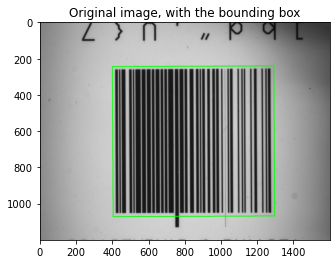

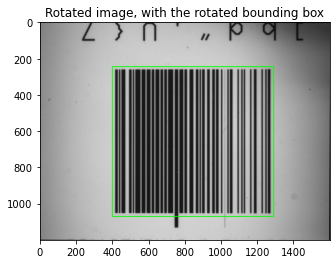

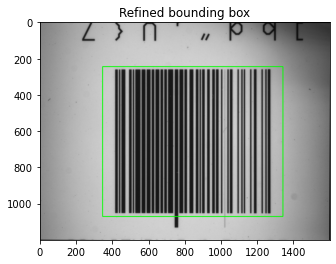

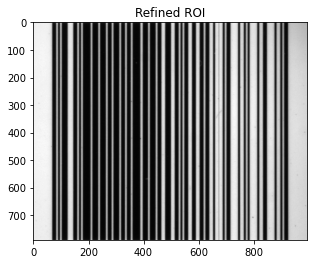

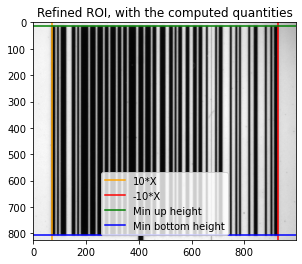

In [537]:
%%time
t = refine_roi(f'../images/{images_paths[0]}')
times.append(t)

Time for detecting the ROI: 0.05407309532165527
Time for rotating the image and the ROI: 0.03829526901245117
Time for computing the ROI quantities: 0.11884331703186035
Time for refining the ROI: 0.055220842361450195
Overall time: 0.266432523727417
Wall time: 266 ms


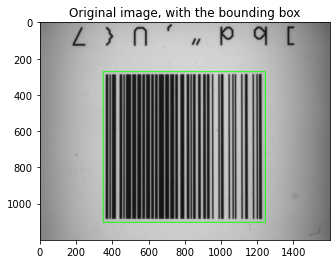

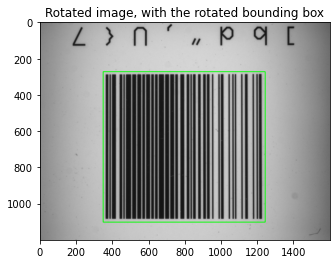

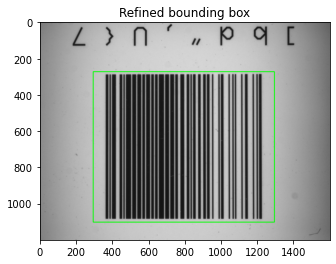

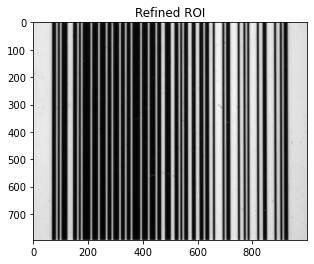

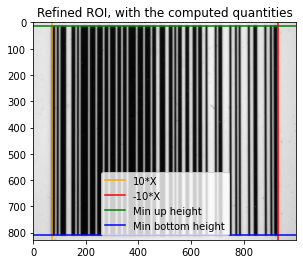

In [538]:
%%time
t = refine_roi(f'../images/{images_paths[1]}')
times.append(t)

Time for detecting the ROI: 0.04234600067138672
Time for rotating the image and the ROI: 0.03313946723937988
Time for computing the ROI quantities: 0.09744977951049805
Time for refining the ROI: 0.0668339729309082
Overall time: 0.23976922035217285
Wall time: 241 ms


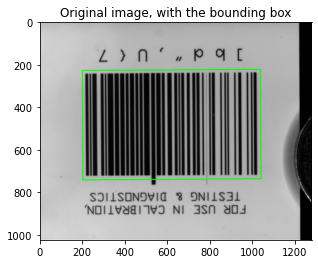

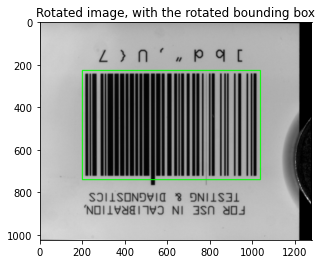

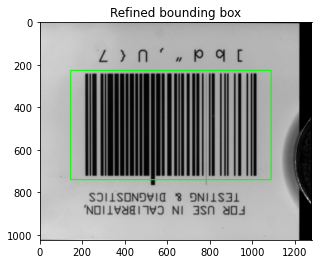

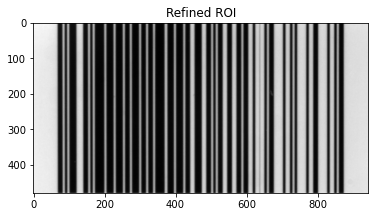

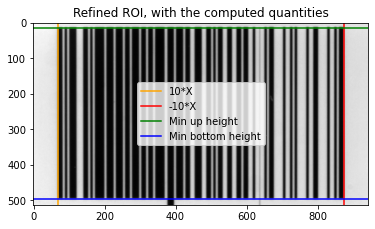

In [539]:
%%time
t = refine_roi(f'../images/{images_paths[2]}')
times.append(t)

Time for detecting the ROI: 0.039553165435791016
Time for rotating the image and the ROI: 0.030634403228759766
Time for computing the ROI quantities: 0.0783998966217041
Time for refining the ROI: 0.0440366268157959
Overall time: 0.19262409210205078
Wall time: 193 ms


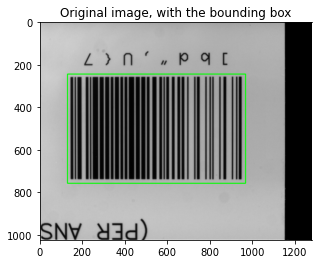

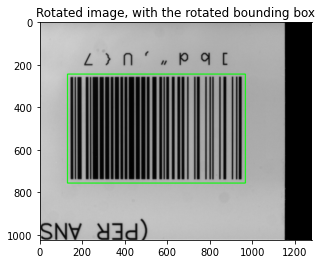

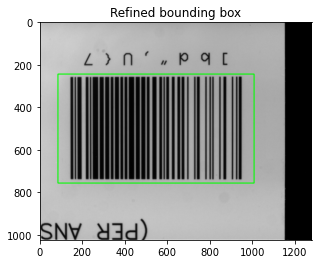

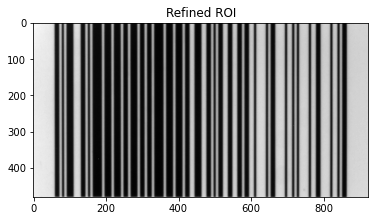

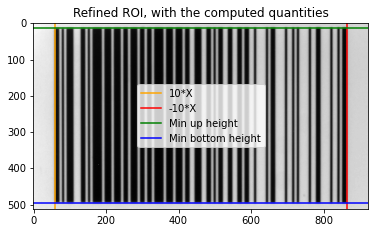

In [540]:
%%time
t = refine_roi(f'../images/{images_paths[3]}')
times.append(t)

Time for detecting the ROI: 0.07757711410522461
Time for rotating the image and the ROI: 0.031516075134277344
Time for computing the ROI quantities: 0.10802459716796875
Time for refining the ROI: 0.04814720153808594
Overall time: 0.26526498794555664
Wall time: 266 ms


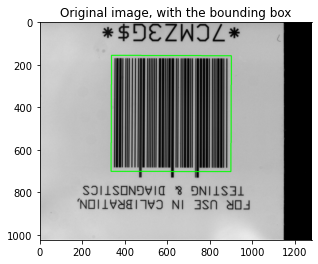

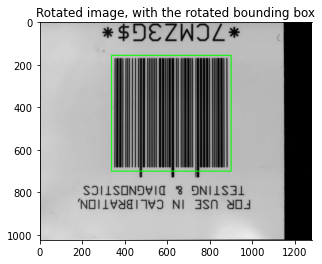

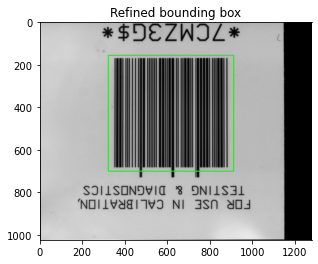

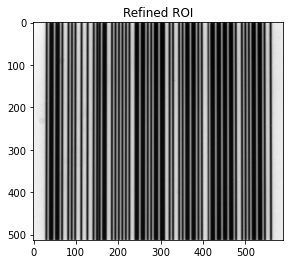

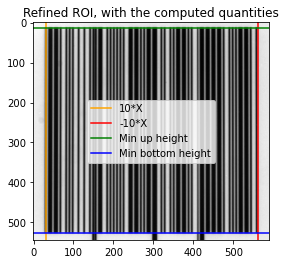

In [541]:
%%time
t = refine_roi(f'../images/{images_paths[4]}')
times.append(t)

Time for detecting the ROI: 0.06202220916748047
Time for rotating the image and the ROI: 0.04474306106567383
Time for computing the ROI quantities: 0.17777657508850098
Time for refining the ROI: 0.06011009216308594
Overall time: 0.3446519374847412
Wall time: 345 ms


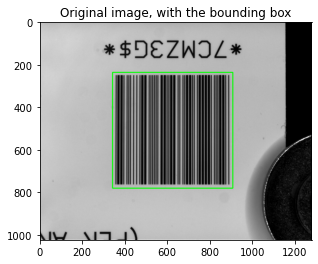

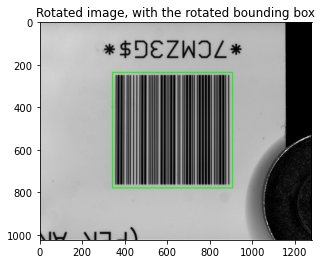

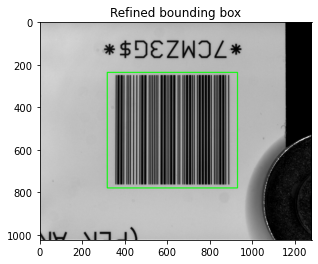

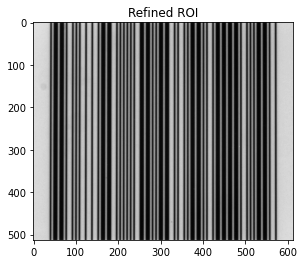

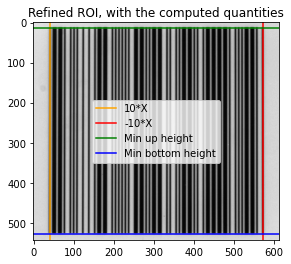

In [542]:
%%time
t = refine_roi(f'../images/{images_paths[5]}')
times.append(t)

Time for detecting the ROI: 0.03924083709716797
Time for rotating the image and the ROI: 0.031719207763671875
Time for computing the ROI quantities: 0.10529065132141113
Time for refining the ROI: 0.05963253974914551
Overall time: 0.23588323593139648
Wall time: 236 ms


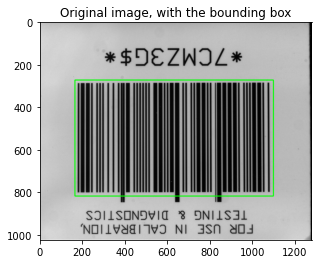

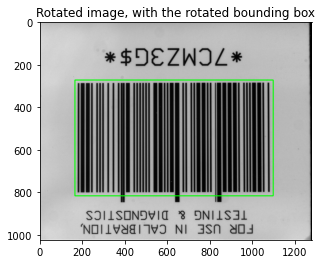

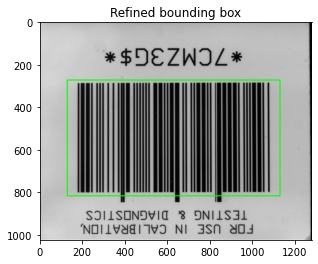

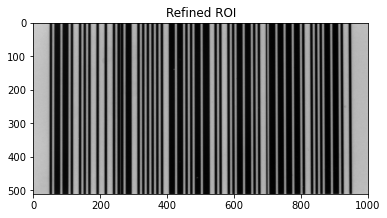

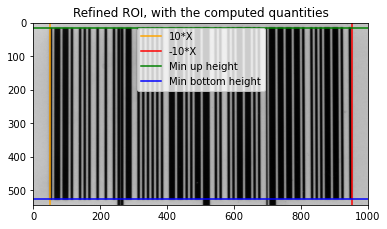

In [543]:
%%time
t = refine_roi(f'../images/{images_paths[6]}')
times.append(t)

Time for detecting the ROI: 0.04022097587585449
Time for rotating the image and the ROI: 0.03010106086730957
Time for computing the ROI quantities: 0.10986590385437012
Time for refining the ROI: 0.04502582550048828
Overall time: 0.22521376609802246
Wall time: 230 ms


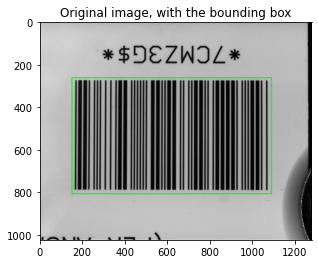

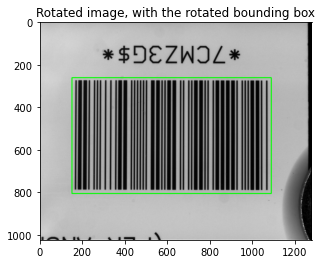

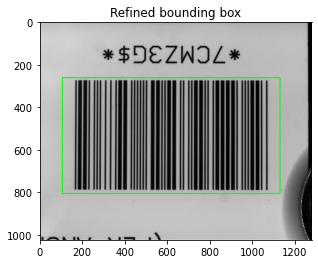

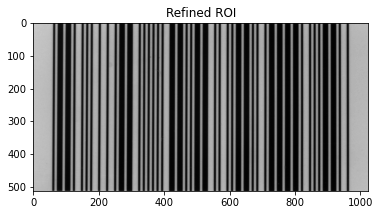

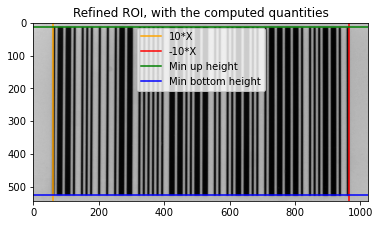

In [544]:
%%time
t = refine_roi(f'../images/{images_paths[7]}')
times.append(t)

Time for detecting the ROI: 0.03783106803894043
Time for rotating the image and the ROI: 0.03017115592956543
Time for computing the ROI quantities: 0.06002211570739746
Time for refining the ROI: 0.050121307373046875
Overall time: 0.1781456470489502
Wall time: 178 ms


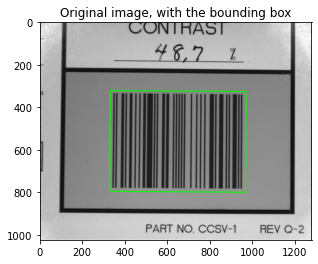

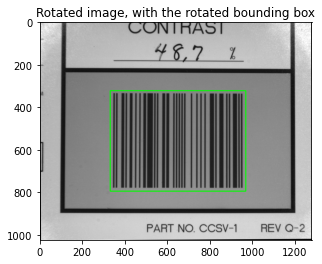

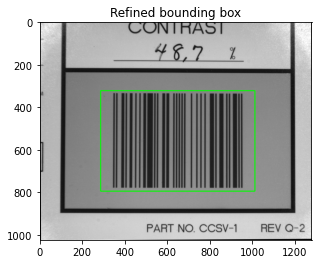

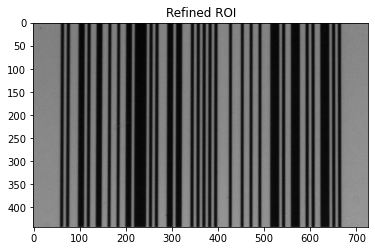

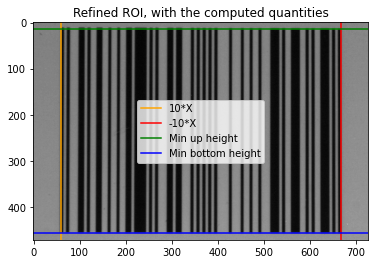

In [545]:
%%time
t = refine_roi(f'../images/{images_paths[8]}')
times.append(t)

Time for detecting the ROI: 0.039743661880493164
Time for rotating the image and the ROI: 0.030282974243164062
Time for computing the ROI quantities: 0.05972647666931152
Time for refining the ROI: 0.0502622127532959
Overall time: 0.18001532554626465
Wall time: 185 ms


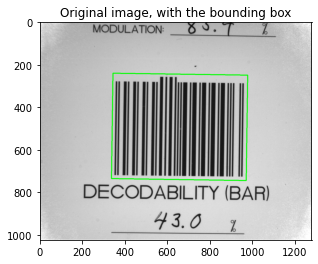

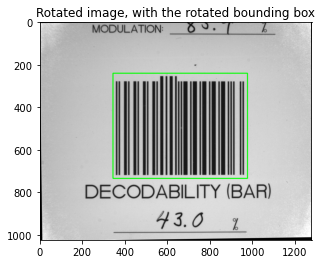

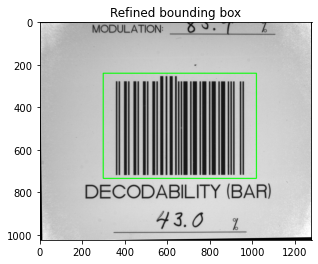

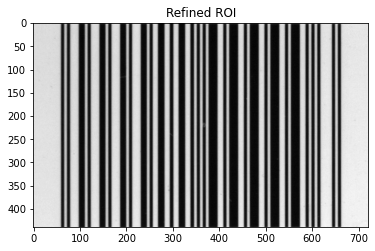

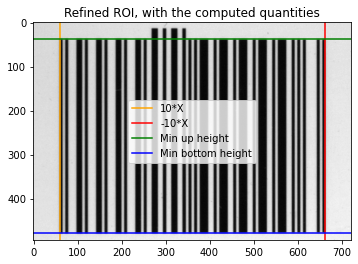

In [546]:
%%time
t = refine_roi(f'../images/{images_paths[9]}')
times.append(t)

In [547]:
"""%%time
t = refine_roi(f'../images/{images_paths[10]}')
times.append(t)"""

"%%time\nt = refine_roi(f'../images/{images_paths[10]}')\ntimes.append(t)"

Time for detecting the ROI: 0.03733682632446289
Time for rotating the image and the ROI: 0.030112743377685547
Time for computing the ROI quantities: 0.06986188888549805
Time for refining the ROI: 0.045081138610839844
Overall time: 0.18239259719848633
Wall time: 182 ms


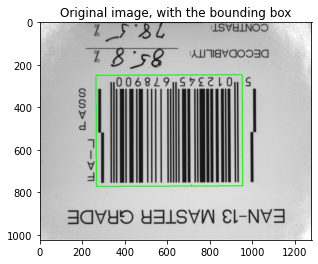

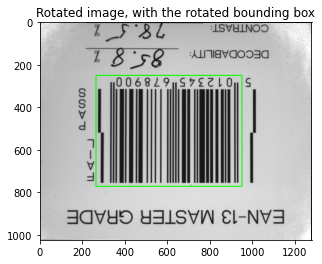

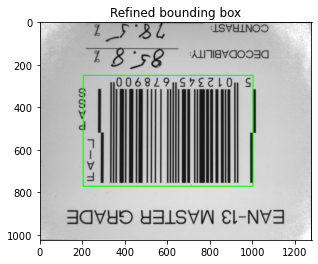

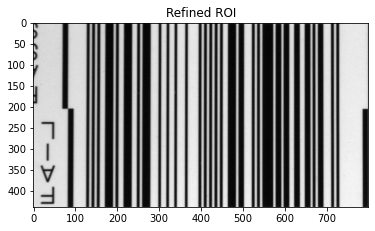

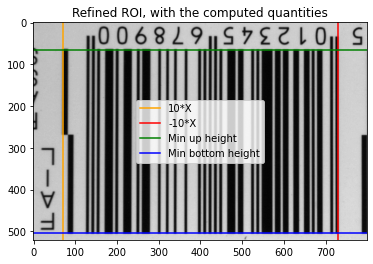

In [548]:
%%time
t = refine_roi(f'../images/{images_paths[11]}')
times.append(t)

In [549]:
"""%%time
t = refine_roi(f'../images/{images_paths[12]}')
times.append(t)"""

"%%time\nt = refine_roi(f'../images/{images_paths[12]}')\ntimes.append(t)"

In [ ]:
%%time
t = refine_roi(f'../images/{images_paths[13]}')
times.append(t)

Time for detecting the ROI: 0.03057122230529785
Time for rotating the image and the ROI: 0.021330595016479492
Time for computing the ROI quantities: 0.04082512855529785
Time for refining the ROI: 0.07994961738586426
Overall time: 0.17267656326293945
Wall time: 173 ms


In [ ]:
%%time
t = refine_roi(f'../images/{images_paths[14]}')
times.append(t)

In [ ]:
%%time
t = refine_roi(f'../images/{images_paths[15]}')
times.append(t)

In [ ]:
%%time
t = refine_roi(f'../images/{images_paths[16]}')
times.append(t)

In [ ]:
%%time
t = refine_roi(f'../images/{images_paths[17]}')
times.append(t)

In [ ]:
%%time
t = refine_roi(f'../images/{images_paths[18]}')
times.append(t)

In [ ]:
%%time
t = refine_roi(f'../images/{images_paths[19]}')
times.append(t)

In [ ]:
%%time
t = refine_roi(f'../images/{images_paths[20]}')
times.append(t)

In [ ]:
%%time
t = refine_roi(f'../images/{images_paths[22]}')
times.append(t)

In [ ]:
%%time
t = refine_roi(f'../images/{images_paths[23]}')
times.append(t)

In [ ]:
%%time
t = refine_roi(f'../images/{images_paths[24]}')
times.append(t)

In [ ]:
%%time
t = refine_roi(f'../images/{images_paths[25]}')
times.append(t)

In [ ]:
%%time
t = refine_roi(f'../images/{images_paths[26]}')
times.append(t)

In [ ]:
%%time
t = refine_roi(f'../images/{images_paths[27]}')
times.append(t)

In [ ]:
%%time
t = refine_roi(f'../images/{images_paths[28]}')
times.append(t)

In [ ]:
%%time
t = refine_roi(f'../images/{images_paths[29]}')
times.append(t)

In [ ]:
%%time
t = refine_roi(f'../images/{images_paths[30]}')
times.append(t)

In [ ]:
%%time
t = refine_roi(f'../images/{images_paths[31]}')
times.append(t)

In [ ]:
%%time
t = refine_roi(f'../images/{images_paths[32]}')
times.append(t)

In [ ]:
%%time
t = refine_roi(f'../images/{images_paths[33]}')
times.append(t)

In [ ]:
%%time
t = refine_roi(f'../images/{images_paths[34]}')
times.append(t)

In [ ]:
%%time
t = refine_roi(f'../images/{images_paths[35]}')
times.append(t)

In [ ]:
%%time
t = refine_roi(f'../images/{images_paths[36]}')
times.append(t)

In [ ]:
%%time
t = refine_roi(f'../images/{images_paths[37]}')
times.append(t)

In [ ]:
%%time
t = refine_roi(f'../images/{images_paths[38]}')
times.append(t)

In [ ]:
%%time
t = refine_roi(f'../images/{images_paths[39]}')
times.append(t)

In [ ]:
%%time
t = refine_roi(f'../images/{images_paths[40]}')
times.append(t)

In [ ]:
%%time
t = refine_roi(f'../images/{images_paths[41]}')
times.append(t)

In [ ]:
%%time
t = refine_roi(f'../images/{images_paths[42]}')
times.append(t)

In [ ]:
%%time
t = refine_roi(f'../images/{images_paths[43]}')
times.append(t)

In [ ]:
%%time
t = refine_roi(f'../images/{images_paths[44]}')
times.append(t)

In [ ]:
%%time
t = refine_roi(f'../images/{images_paths[45]}')
times.append(t)

In [ ]:
%%time
t = refine_roi(f'../images/{images_paths[46]}')
times.append(t)

In [ ]:
%%time
t = refine_roi(f'../images/{images_paths[47]}')
times.append(t)

In [ ]:
%%time
t = refine_roi(f'../images/{images_paths[48]}')
times.append(t)

In [ ]:
%%time
t = refine_roi(f'../images/{images_paths[49]}')
times.append(t)

In [ ]:
%%time
t = refine_roi(f'../images/{images_paths[50]}')
times.append(t)

In [ ]:
%%time
t = refine_roi(f'../images/{images_paths[51]}')
times.append(t)

In [ ]:
%%time
t = refine_roi(f'../images/{images_paths[52]}')
times.append(t)

In [ ]:
%%time
refine_roi('../other images/1.png')

In [ ]:
%%time
refine_roi('../other images/2.jpg')

In [ ]:
%%time
refine_roi('../other images/3.jpg')  # NO ROTATION INVARIANCE

### Average time (milliseconds)

In [ ]:
np.mean(times)